# 🧹 LIMPIEZA CIVITATIS

# 📥 Imports y configuración

In [2]:
import pandas as pd
import re, unicodedata
import matplotlib.pyplot as plt
from pathlib import Path

# Ajusta estas rutas a tu archivo
INPUT_CSV = Path("atracciones_civitatis-Copy1.csv")   # <-- cambia el nombre si hace falta
OUTPUT_CSV = INPUT_CSV.with_name(INPUT_CSV.stem + "_categorizado.csv")
PLOT_PATH  = INPUT_CSV.with_name("distribucion_categorias.png")

pd.set_option("display.max_colwidth", 150)  # ver bien los textos largos

# 📂 Carga de datos de Civitatis

In [4]:
df = None
last_err = None
for enc in ["utf-8", "latin1", "utf-16"]:
    try:
        df = pd.read_csv(INPUT_CSV, encoding=enc)
        print("Leído con codificación:", enc)
        break
    except Exception as e:
        last_err = e

if df is None:
    raise RuntimeError(f"No se pudo leer el CSV. Último error: {last_err}")

df.head(3)

Leído con codificación: utf-8


,id,url,title,address,review_score,review_count,description,price
0,comfort_card_228,https://www.civitatis.com/es/barcelona/visita-guiada-sagrada-familia/,Visita de la Sagrada Familia sin colas,Barcelona,"8,5 / 10",3.830,Si hay un lugar que nadie puede perderse en Barcelona es la Sagrada Familia. En esta visita descubriremos la obra maestra de Gaudí saltándonos sus...,55 €
1,comfort_card_1365,https://www.civitatis.com/es/barcelona/free-tour-barcelona/,Free tour por Barcelona,Barcelona,"9,5 / 10",48.997,"El free tour por Barcelona es la mejor forma de explorar a pie la capital catalana. Conoceremos las calles, plazas y monumentos imprescindibles de...",¡Gratis!
2,comfort_card_591,https://www.civitatis.com/es/barcelona/visita-sagrada-familia-torres/,Sagrada Familia con subida a las torres,Barcelona,"7,7 / 10",1.677,En esta visita a la Sagrada Familia conoceremos el lugar más famoso de Barcelona y subiremos a una de sus torres. ¡Tendremos una vista inmejorable...,109 €


# 📝 Transformación de datos

In [6]:
# Ajusta según tus columnas reales (p.ej., "title","description" o "nombre","descripcion")
TEXT_COLUMNS = [c for c in ["title","description"] if c in df.columns]
print("Columnas usadas:", TEXT_COLUMNS)

Columnas usadas: ['title', 'description']


# 🧩 Unión y combinación de tablas

In [8]:
def strip_accents(s: str) -> str:
    return ''.join(ch for ch in unicodedata.normalize('NFD', s) if unicodedata.category(ch) != 'Mn')

def build_text(row, columns):
    parts = [str(row[c]) for c in columns if c in row and pd.notna(row[c])]
    text = " | ".join(parts).lower()
    return strip_accents(text)

# Vista rápida de cómo queda el texto de la primera fila
if len(df) > 0:
    print(build_text(df.iloc[0], TEXT_COLUMNS)[:300])

visita de la sagrada familia sin colas | si hay un lugar que nadie puede perderse en barcelona es la sagrada familia. en esta visita descubriremos la obra maestra de gaudi saltandonos sus colas.


# 🏷️ Renombrado y creación de columnas

In [10]:
KW = {
    "museo": [
        "museo","museum","pinacoteca","galeria de arte",
        "exposicion","exhibicion","exhibition",
        # si quieres considerar centros de arte/foto/musica como "museo":
        "arte","ciencia","fotografia","musica","fundacion","galeria"
    ],
    "vida nocturna": [
        "vida nocturna","noche","club","discoteca","pub","bar de copas",
        "fiesta","nightlife","night club","nightclub","cocktail","coctel","karaoke"
    ],
    "deporte": [
        "deporte","futbol","baloncesto","surf","kayak","senderismo","hiking",
        "ciclismo","bici","mtb","ski","esqui","rafting","buceo","snorkel","diving",
        "climbing","escalada","vela","golf","tenis","padel","parapente","quad","atv",
        "kite","windsurf","yoga","running","maraton"
    ],
    "playa": [
        "playa","beach","caleta","cala","bahia","costa","chiringuito","litoral","orilla del mar"
    ],
    "comida": [
        "tapas","comida","gastron","food","restaurante","bodega","vinoteca","vino","cerveza",
        "beer","degustacion","cata","queso","mercado","paella","cocina","gourmet",
        "street food","brunch","cafeteria","bar de tapas"
    ],
    "cultura": [
        "catedral","iglesia","monasterio","histori","patrimonio","arte","arquitect",
        "teatro","palacio","castillo","ruina","yacimiento","mezquita","sinagoga",
        "barrio","plaza","monumento","mirador","tradicional","folclore","flamenco",
        # modernismo / gaudi / barcelona
        "sagrada familia","basilica","gaudi","templo expiatorio","modernismo","modernisme",
        "obra de gaudi","eixample","park guell","parque guell","recinto modernista","sant pau",
        "palau de la musica","palacio de la musica","montjuic"
    ],
    "hotel": [
        "hotel","hostal","albergue","parador","resort","apartahotel"
    ],
    "tour": [
        "tour","visita guiada","free tour","excursion","recorrido","ruta","paseo",
        "hop-on","autobus turistico","city tour","guia","experiencia","actividad",
        "day trip","entrada sin colas","fast track"
    ],
    # ===== NUEVA CATEGORIA: OCIO (parques, zoo, acuarios, etc.) =====
    "ocio": [
        "zoo","acuario","aquarium","aquopolis","aqualand","faunia",
        "parque de atracciones","parque tematico","parque temático",
        "holiday world","palmitos park","cocodrilo park","safari","jeep safari",
        "aqualandia","water park","parque acuatico","parque acuático",
        "teleferico","teleferico de montjuic","teleferico de montjuic"
    ]
}

# Compilar las palabras clave a patrones regex (ya sin acentos)
def compile_patterns(kw_dict):
    patterns = {}
    for cat, words in kw_dict.items():
        p_list = []
        for w in words:
            w_norm = strip_accents(w.lower())
            # si es "palabra" alfanumérica, usa bordes de palabra (\b)
            if all(ch.isalnum() or ch.isspace() for ch in w_norm):
                p = re.compile(r"\b" + re.escape(w_norm) + r"\b")
            else:
                p = re.compile(re.escape(w_norm))
            p_list.append(p)
        patterns[cat] = p_list
    return patterns

PATTERNS = compile_patterns(KW)

# Orden de decisión: la primera categoría que haga match "gana"
PRIORITY =  ["museo","cultura","ocio","vida nocturna","deporte","playa","comida","hotel","tour"]

# 🏷️ Renombrado y creación de columnas

In [12]:
def classify_text(text: str) -> str:
    if not text:
        return "otro"
    for cat in PRIORITY:
        for pat in PATTERNS[cat]:
            if pat.search(text):
                return cat
    return "otro"

# Construir el texto por fila y clasificar
text_series = df.apply(lambda r: build_text(r, TEXT_COLUMNS), axis=1)
df["categoria_experiencia"] = text_series.map(classify_text)

df[[c for c in (TEXT_COLUMNS[:2] + ["categoria_experiencia"]) if c in df.columns]].head(10)

,title,description,categoria_experiencia
0,Visita de la Sagrada Familia sin colas,Si hay un lugar que nadie puede perderse en Barcelona es la Sagrada Familia. En esta visita descubriremos la obra maestra de Gaudí saltándonos sus...,cultura
1,Free tour por Barcelona,"El free tour por Barcelona es la mejor forma de explorar a pie la capital catalana. Conoceremos las calles, plazas y monumentos imprescindibles de...",tour
2,Sagrada Familia con subida a las torres,En esta visita a la Sagrada Familia conoceremos el lugar más famoso de Barcelona y subiremos a una de sus torres. ¡Tendremos una vista inmejorable...,cultura
3,Excursión a Montserrat con tren cremallera,"En esta excursión a Montserrat podréis visitar el Santuario de la Patrona de Cataluña, a 1236 metros de altura, y llegar en tren cremallera.",tour
4,Traslados en Barcelona,"Servicio privado, puerta a puerta y al mejor precio. Un chófer os esperará en el aeropuerto, en el hotel o donde queráis para llevaros a vuestro d...",hotel
5,Tour por la Sagrada Familia y el Parque Güell,"En este tour por Barcelona visitaremos la Sagrada Familia y el Parque Güell, las dos grandes joyas de la arquitectura modernista de Antonio Gaudí.",cultura
6,Visita guiada por el Parque Güell,En esta visita guiada por el Parque Güell de Barcelona visitaremos una de las grandes joyas modernistas de Antonio Gaudí en la capital de Cataluña.,cultura
7,Tour de Barcelona al completo en grupo reducido,"La Sagrada Familia, el Parque Güell, el Barrio Gótico... Acompañadnos en este tour de Barcelona al completo en el que visitaremos lo mejor de la C...",cultura
8,Free tour de Gaudí y la Barcelona modernista,Acompañadnos a visitar el corazón de Barcelona en este free tour de Gaudí que nos llevará a descubrir los principales símbolos del modernismo en E...,cultura
9,Free tour nocturno por el Barrio Gótico,En este free tour nocturno por el Barrio Gótico de Barcelona conoceremos la historia de la Ciudad Condal mientras contemplamos su preciosa ilumina...,cultura


# 📊 Agregaciones y conteos

categoria_experiencia
tour             292
cultura          150
museo            109
playa             88
deporte           82
otro              58
comida            34
ocio              29
hotel              8
vida nocturna      6
Name: count, dtype: int64


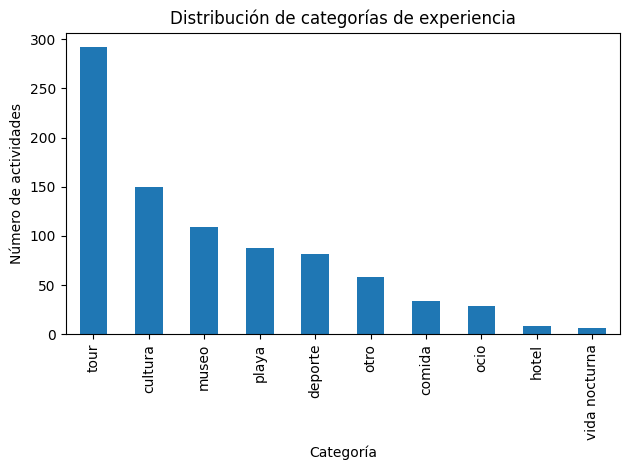

Gráfico guardado en: distribucion_categorias.png


In [14]:
counts = df["categoria_experiencia"].value_counts(dropna=False)
print(counts)

plt.figure()
counts.plot(kind="bar")
plt.title("Distribución de categorías de experiencia")
plt.xlabel("Categoría")
plt.ylabel("Número de actividades")
plt.tight_layout()
plt.savefig(PLOT_PATH)
plt.show()

print("Gráfico guardado en:", PLOT_PATH)

# 🏷️ Renombrado y creación de columnas

In [18]:
# Filtrar solo los que quedaron en "otro"
otros = df[df["categoria_experiencia"] == "otro"]
# Columnas que quieres revisar (ajusta si tienes otras relevantes)
cols_revisar = [c for c in ["title","description","nombre","descripcion","tags","address"] if c in df.columns]

# Mostrar primeras filas
otros[cols_revisar].head(50)


,title,description,address
12,Tarjeta eSIM Civitatis España,"Si vais a viajar por España, con esta tarjeta eSIM con Internet podréis conectaros fácilmente a la red y mantener el contacto con vuestros familia...",Barcelona
101,Barcelona Card,"La tarjeta Barcelona Card proporciona acceso sin colas a los museos más importantes de la Ciudad Condal, transporte público ilimitado y un montón ...",Barcelona
102,Hola Barcelona Travel Card,"La tarjeta Hola Barcelona Travel Card permite el uso ilimitado del transporte público de Barcelona: metro, autobús, tranvía y trenes suburbanos.",Barcelona
108,Go City: Barcelona Explorer Pass,"Con el pase turístico Go City: Barcelona Explorer Pass tendréis acceso a 2, 3, 4, 5, 6 o 7 atracciones de la capital catalana. ¡Ahorraréis dinero!",Barcelona
132,Autobús entre el Aeropuerto de El Prat y Barcelona,Este servicio de traslado en el Aerobús es la opción más cómoda y fácil para desplazarse entre el centro de Barcelona y el Aeropuerto Josep Tarrad...,Barcelona
134,Autobús entre el Aeropuerto de Gerona y Barcelona,Viajad de la forma más cómoda entre el Aeropuerto de Gerona y Barcelona con este servicio de transporte en autobús. ¡Llegaréis en tan solo una hor...,Barcelona
136,Barcelona Card Express,Con la tarjeta Barcelona Card Express obtendrás descuentos en atracciones turísticas y podrás usar el transporte público sin límites durante 48 ho...,Barcelona
151,Avistamiento de cetáceos por Puerto Rico,Subid a un barco de suelo transparente y contemplad la vida marina de Gran Canaria. Tendréis la oportunidad de navegar junto a delfines y ballenas.,Gran Canaria
158,Catamarán por las costas de Puerto Rico,En este catamarán por las costas de Puerto Rico disfrutaremos de un día repleto de diversión en aguas del océano Atlántico. ¿Preparados para la tr...,Gran Canaria
197,Ferry a Tenerife,¿A qué esperáis para comprar vuestro billete de ferry a Tenerife desde Gran Canaria? Zarparéis desde Agaete rumbo a la isla más grande del archipi...,Gran Canaria


# 📥 Imports y configuración

In [35]:
import re
import numpy as np
import pandas as pd

# --- 1) Convertir review_score a escala 0–10 de forma robusta ---
def to_10_scale(x):
    """
    Admite: 4.5, '4,5', '4.5/5', '8/10', 85 (porcentaje), etc.
    Devuelve un float en 0–10 o NaN.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(",", ".")
    
    # Caso tipo "4.5/5" o "8/10"
    m = re.match(r'^\s*(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)\s*$', s)
    if m:
        num = float(m.group(1))
        den = float(m.group(2))
        if den > 0:
            return (num / den) * 10
        return np.nan
    
    # Caso numérico "suelto"
    try:
        val = float(s)
    except:
        return np.nan
    
    # Heurísticos de escala
    if 0 <= val <= 5:
        return val * 2               # estaba en 0–5 -> lo pasamos a 0–10
    if 0 <= val <= 10:
        return val                   # ya está en 0–10
    if 0 <= val <= 100:
        return val / 10.0            # porcentaje -> 0–10
    return np.nan

df["score_10"] = df["review_score"].apply(to_10_scale)

# --- 2) Mapear a tus 3 bandas de sentimiento ---
def map_sentimiento_10(v):
    if pd.isna(v):
        return "Desconocido"
    # Umbrales: <5 Malo, [5,7) Neutro, >=7 Abierto
    if v < 5:
        return "Malo"
    elif v < 7:
        return "Neutro"
    else:
        return "Bueno"

df["Sentimiento"] = df["score_10"].apply(map_sentimiento_10)

# --- 3) Ciudad ---
# Si tienes una columna 'address' con "calle, ciudad", sacamos lo último
def extraer_ciudad(address):
    if pd.isna(address):
        return None
    partes = str(address).split(",")
    return partes[-1].strip()

df["ciudad"] = df["address"].map(extraer_ciudad)

# --- 4) Experiencia ---
# Ya la tienes creada en tu pipeline anterior:
# df["Experiencia"] = df["categoria_experiencia"]

# --- 5) Fecha ---
# Usa la columna que tengas en tu CSV, por ejemplo 'date'
if "date" in df.columns:
    df["Fecha"] = pd.to_datetime(df["date"], errors="coerce")
else:
    df["Fecha"] = None

# --- 6) Fuente ---
df["fuente"] = "Civitatis"

# --- 7) Texto (solo el título de la actividad) ---
df["Texto"] = df["title"]

df_final = df[["Texto","Sentimiento","ciudad","categoria_experiencia","Fecha","fuente"]]

# Si quieres renombrar para que quede bonito:
df_final = df_final.rename(columns={"categoria_experiencia": "Experiencia"})

# --- 9) Vista previa ---
print(df_final.head(10))

# --- 10) Guardar ---
df_final.to_csv("dataset_final_civitatis_categorizado.csv", index=False, encoding="utf-8")

                                             Texto Sentimiento     ciudad  \
0           Visita de la Sagrada Familia sin colas       Bueno  Barcelona   
1                          Free tour por Barcelona       Bueno  Barcelona   
2          Sagrada Familia con subida a las torres       Bueno  Barcelona   
3       Excursión a Montserrat con tren cremallera       Bueno  Barcelona   
4                           Traslados en Barcelona       Bueno  Barcelona   
5    Tour por la Sagrada Familia y el Parque Güell       Bueno  Barcelona   
6                Visita guiada por el Parque Güell       Bueno  Barcelona   
7  Tour de Barcelona al completo en grupo reducido       Bueno  Barcelona   
8     Free tour de Gaudí y la Barcelona modernista       Bueno  Barcelona   
9          Free tour nocturno por el Barrio Gótico       Bueno  Barcelona   

  Experiencia Fecha     fuente  
0     cultura  None  Civitatis  
1        tour  None  Civitatis  
2     cultura  None  Civitatis  
3        tour  None 